In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from unity.eda_func import EdaFunc as edf
from unity.fea_eda_func import FeaEdaFunc as fef
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
import os
import json
import datetime
import gc
import scorecardpy as sc
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
# import pickle
# import joblib
# import pandas_profiling

% matplotlib inline

In [2]:
bdbank = ini.pd.read_pickle('data/bd/bdbank.pkl')
bdtag = ini.pd.read_csv('data/tag/bd_tag_avli.csv')

In [7]:
# bdbank.head()
bdbank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168028 entries, 0 to 168027
Columns: 140 entries, ID to livingPhoto
dtypes: datetime64[ns](2), float64(7), int64(1), object(130)
memory usage: 179.5+ MB


In [331]:
bdbank=bdbank[bdbank['TRANSACTION_TYPE']=='apply']

In [5]:
bdtag.head()

,dubil_no,cert_no,ovdue_days,lon_dt
0,4176499214121897291,350521197206100033,0,2020-04-02
1,4176498286408975032,640321198510110730,0,2020-03-29
2,4170320439806389279,12022219960310582X,0,2020-03-26
3,4149489607891218124,441623199705305789,0,2020-03-23
4,4176499660798518798,110102197111170818,0,2020-04-02


In [332]:
bdtag['tag'] = 0
bdtag.loc[bdtag['ovdue_days']>30,'tag'] = 1
bdtag = bdtag.groupby('cert_no')['tag'].max().reset_index(name='tag')

In [333]:
bdbank = bdbank.sort_values('CREATED_DATE',ascending=0).drop_duplicates('ID_CARD_NO',keep='last')

In [334]:
bdbank = bdbank.dropna(subset=['ID','ID_CARD_NO'])
bdbank = bdbank.rename({'ID_CARD_NO':'cert_no'},axis=1)
bdmain = bdbank.merge(bdtag,on='cert_no')
# bdmain = pd.merge(bdbank,bdtag,on='cert_no',how = 'left')
del bdbank,bdtag

In [ ]:
bd_avli = pd.read_csv(r'./merge_with_fake_4.csv')

# 一、数据清洗

## 1.1 剔除单一值、缺失>0.7、相关性>0.7

In [335]:
drop_feas = {'ID','BANK_CARD_NO','MOBILE_NO','TRANSACTION_ID','CUST_NAME','ORDER_NO','idpicture0','livingPhoto',
             'photowithidcard','orderId','reasonMsg','unionLoanUsed','TRANSACTION_TYPE','zxSex',
             'TRANSACTION_ID','BANK_CARD_NO','UPDATED_DATE','zxDomicile','zxPermanentAddress'}

bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

In [148]:
bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

In [336]:
fs = FeatureSelector(data=bdmain.drop('tag',axis=1),labels=bdmain['tag'])
fs.identify_missing(0.8)
fs.identify_single_unique()
fs.identify_collinear(0.8)
fs_drop = fs.check_removal()

37 features with greater than 0.80 missing values.

7 features with a single unique value.

0 features with a correlation magnitude greater than 0.80.

Total of 44 features identified for removal


In [337]:
drop_feas = drop_feas | set(fs_drop)

In [4]:
bdmain.head()

NameError: name 'bdmain' is not defined

In [338]:
bdmain = bdmain.drop(drop_feas,axis=1)

## 1.2 异常值处理

In [14]:
# bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

## 1.3 划分数据集

In [341]:
train_x,test_x,train_y,test_y = train_test_split(bdmain,bdmain['tag'],test_size=0.3,shuffle=True,random_state=123)

In [340]:
train_x =  bdmain.dropna(subset=['tag'])
train_y = train_x['tag']
train_x = train_x.drop('tag',axis=1)
test_x = bdmain.loc[bdmain[np.isnan(bdmain['tag'])].index,:].drop('tag',axis=1)

In [39]:
train_x.shape

(26420, 86)

In [40]:
train_x['tag'].value_counts()

0    26104
1      316
Name: tag, dtype: int64

In [41]:
test_x['tag'].value_counts()

0    11188
1      136
Name: tag, dtype: int64

# 二、特征工程

## 2.1 日期、百分比、地址特征处理

### 2.1.1 日期特征衍生

In [342]:
date_feas = train_x.loc[:,train_x.columns.str.contains('Date|LastMonth|DATE|FirstLoan|Update')].columns

In [325]:
date_feas

Index(['CREATED_DATE', 'zxLoanRcyDelqDate', 'zxHouseFundPayLastMonth',
       'zxMaxUpdated', 'zxFirstLoanMonth', 'zxFirstCreCardDate',
       'zxLoanRcyUpdateDate', 'zxFirstLoanDate', 'zxCreditCardRcyUpdateDate',
       'zxRcyQueryDate', 'zxHouseFundRecordUpdate', 'zxCreditCardRcyDelqDate'],
      dtype='object')

In [55]:
train_x[date_feas].dtypes

CREATED_DATE                 datetime64[ns]
zxHouseFundPayLastMonth              object
zxMaxUpdated                         object
zxFirstLoanMonth                     object
zxFirstCreCardDate                   object
zxLoanRcyUpdateDate                  object
zxFirstLoanDate                      object
zxCreditCardRcyUpdateDate            object
zxRcyQueryDate                       object
zxHouseFundRecordUpdate              object
zxCreditCardRcyDelqDate              object
dtype: object

In [343]:
train_x['zxHouseFundPayLastMonth'] = train_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
test_x['zxHouseFundPayLastMonth'] = test_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
train_x.loc[:,date_feas] = train_x[date_feas].astype('datetime64[ns]')
test_x.loc[:,date_feas] = test_x[date_feas].astype('datetime64[ns]')

In [344]:
for c in date_feas[:-1]:
    train_x[f'{c}_diff_londt'] = abs((train_x['CREATED_DATE'] - train_x[c]).dt.days)
    train_x[f'{c}_diff_londt'] = train_x[f'{c}_diff_londt'].fillna(-9999)
    test_x[f'{c}_diff_londt']  = abs((test_x['CREATED_DATE'] - test_x[c]).dt.days)
    test_x[f'{c}_diff_londt'] = test_x[f'{c}_diff_londt'].fillna(-9999)

In [345]:
train_x = train_x.drop(date_feas,axis=1)
test_x = test_x.drop(date_feas,axis=1)

### 2.1.2 比例特征处理

In [346]:
train_x['zxHouseFundCompanyRate'] = train_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
train_x['zxHouseFundSelfRate'] = train_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundCompanyRate'] = test_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundSelfRate'] = test_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100

### 2.1.3 地址特征处理

In [347]:
train_x = fef.build_cert_refer_feas(train_x,cert_cols='cert_no')
test_x = fef.build_cert_refer_feas(test_x,cert_cols='cert_no')

## 2.2 类别特征处理

In [348]:
def bin_group_single(df, col, target):
    """
    单个特征iv,woe
    """
    regroup = df.groupby([col])['tag'].agg(['count','sum']).replace(0,0.0001)\
                .rename({'count':'total','sum':'bad'},axis=1)\
                .assign(variable=col,
                        good=lambda x:x['total']-x['bad'],
                        badprob = lambda x:x['bad']/x['total'],
                        DistrBad = lambda x:x['good']/sum(x['good']),
                        DistrGood = lambda x:x['bad']/sum(x['bad']),
                        woe = lambda x:ini.np.log(x['DistrBad']/x['DistrGood']),
                        bin_iv = lambda x:(x['DistrBad']-x['DistrGood'])*x['woe'],
                        total_iv = lambda x:sum(x.bin_iv))
    regroup.reset_index(level=0,inplace=True)
    return regroup

def bin_group(df, cols, target,missing=True):
    """
    """
    bin_df_dicts = {}
    if missing: df.loc[:,cols] = df.fillna('missing')
    for c in cols:
        bin_df = bin_group_single(df,c,target)
        bin_df_dicts[c] = bin_df
    return bin_df_dicts

def badrate_ply(df,cols, bin_df_dicts,missing=True):
    """
    badrate编码转化
    """
    if missing: df.loc[:,cols] = df.fillna('missing')
    bin_badp_dicts = {c:dict(zip(bin_df_dicts[c][c],bin_df_dicts[c]['badprob'])) for c in cols}
    df.replace(bin_badp_dicts,inplace=True)
    return df

In [349]:
train_x = train_x.loc[:,train_x.columns.str.contains('zx|tag')]
test_x = test_x.loc[:,test_x.columns.str.contains('zx|tag')]

In [350]:
cat_feas = set(train_x.loc[:,train_x.columns.str.contains('Status|Type|Code|Sex|Seg|LoanUse|Section|ocr|Edu|Career|Mari')].columns)

In [351]:
cat_feas_info = edf.get_features_type(train_x[cat_feas])['cat_feas']

In [31]:
cat_feas_info

zxCreditCardDelqStatus90To180Days    13
zxLoanDelqStatus60To90Days           14
zxLoanDelqStatus90To180Days          14
zxEducation                           8
zxCreCardStatus4                      4
zxCreCardStatus5                      6
zxCreCardStatus3                      3
zxLoanDelqStatus6To12Months          14
zxCreditCardDelqStatus24Months       13
zxCreditCardDelqStatus6To12Months    13
zxLoanDelqStatus30Dayyues             6
zxCareer                             10
zxLoanDelqStatus30To60Days           14
zxMaritalStatus                       5
zxHouseFundPayStatus                  4
zxCreCardStatus1                      4
zxCreditCardDelqStatus30Dayyues       7
zxCreditCardDelqStatus60To90Days     13
zxCreditCardDelqStatus30To60Days     13
dtype: int64

In [20]:
bdmain.shape

(37744, 86)

* <font color=red face=仿宋 size=4>lightgbm测试</font>

In [277]:
train_x.loc[:,cat_feas_info.index] = train_x.astype('category')
test_x.loc[:,cat_feas_info.index] = test_x.astype('category')
obj_feas = train_x.select_dtypes(include=['object','int']).columns
train_x.loc[:,obj_feas] = train_x[obj_feas].astype(float)
test_x.loc[:,obj_feas] = test_x[obj_feas].astype(float)

from lightgbm import LGBMClassifier
lgbc = LGBMClassifier(random_state=123,is_unbalanced=True)
lgbc.fit(train_x.drop('tag',axis=1),train_y)

predict_train_y = lgbc.predict_proba(train_x.drop('tag',axis=1))[:,1]
print(roc_auc_score(train_y,predict_train_y))
predict_test_y = lgbc.predict_proba(test_x.drop('tag',axis=1))[:,1]
print(roc_auc_score(test_y,predict_test_y))
fpr,tpr,_= roc_curve(test_y,predict_test_y)
print(abs(fpr-tpr).max())

0.9999996363135579
0.6756286935582242
0.3041020841658079


In [253]:
predict_test_y[predict_test_y>0.5]

array([0.52438307, 0.87572071, 0.58311135, 0.74805788, 0.5806765 ,
       0.50213322, 0.82270635, 0.54706411])

In [321]:
# train_x.loc[:,cat_feas_info.index] = train_x.astype('category')
# test_x.loc[:,cat_feas_info.index] = test_x.astype('category')
labelencode_feas = cat_feas_info.index
for f in labelencode_feas:
    label_trans = LabelEncoder()
    train_x[f] = label_trans.fit_transform(train_x[f])
    test_x[f] = label_trans.fit_transform(test_x[f])
obj_feas = train_x.select_dtypes(include=['object','int']).columns
train_x.loc[:,obj_feas] = train_x[obj_feas].astype(float)
test_x.loc[:,obj_feas] = test_x[obj_feas].astype(float)
smo = SMOTE(sampling_strategy = {1:850},random_state = 42)
x1 = train_x.drop('tag',axis=1)
y1 = train_y
x1 = x1.fillna(0)
y1 = y1.fillna(0)
x_smo,y_smo = smo.fit_sample(x1,y1)
print(y_smo.value_counts())
from lightgbm import LGBMClassifier
lgbc = LGBMClassifier(random_state=123)
lgbc.fit(x_smo,y_smo)

predict_train_y = lgbc.predict_proba(x_smo)[:,1]
print(roc_auc_score(y_smo,predict_train_y))
predict_test_y = lgbc.predict_proba(test_x.drop('tag',axis=1))[:,1]
print(roc_auc_score(test_y,predict_test_y))
fpr,tpr,_= roc_curve(test_y,predict_test_y)
print(abs(fpr-tpr).max())

0    26104
1      850
Name: tag, dtype: int64
0.9999972508157415
0.677710099055711
0.3002297629813456


### 2.2.1 类别  < 4 的特征直接label_encode

In [352]:
labelencode_feas = cat_feas_info[cat_feas_info < 4].index

In [353]:
for f in labelencode_feas:
    label_trans = LabelEncoder()
    label_trans.fit(train_x[f])
    train_x[f] = label_trans.transform(train_x[f])
    test_x[f] = label_trans.transform(test_x[f])

In [354]:
lab_bin_dicts = bin_group(train_x,labelencode_feas,'tag')

### 2.2.2 类别 >= 4 并且<= 8 的直接分箱

In [355]:
woeenc_feas = cat_feas_info[(cat_feas_info >= 4)&(cat_feas_info <= 8)].index

In [38]:
woeenc_feas

Index(['zxEducation', 'zxCreCardStatus4', 'zxCreCardStatus5',
       'zxLoanDelqStatus30Dayyues', 'zxMaritalStatus', 'zxHouseFundPayStatus',
       'zxCreCardStatus1', 'zxCreditCardDelqStatus30Dayyues'],
      dtype='object')

In [356]:
# badp_bin_dicts = bin_group(train_x,badencode_feas,'tag')
# train_x = badrate_ply(train_x,badencode_feas,badp_bin_dicts)
# test_x = badrate_ply(test_x,badencode_feas,badp_bin_dicts)
woeenc_bin_dicts = bin_group(train_x,woeenc_feas,'tag')

In [40]:
woeenc_bin_dicts['zxHouseFundPayStatus']

,zxHouseFundPayStatus,total,bad,variable,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,missing,16688,233,zxHouseFundPayStatus,16455,0.013962,0.630363,0.737342,-0.156755,0.016769,0.120537
1,封存,3196,44,zxHouseFundPayStatus,3152,0.013767,0.120748,0.139241,-0.142499,0.002635,0.120537
2,缴交,5823,31,zxHouseFundPayStatus,5792,0.005324,0.221882,0.098101,0.816144,0.101023,0.120537
3,销户,713,8,zxHouseFundPayStatus,705,0.011220,0.027007,0.025316,0.064655,0.000109,0.120537


In [357]:
adj_cat_feas = ['zxLoanDelqStatus30Dayyues']
adj_cat_bin = {aj:woeenc_bin_dicts[aj] for aj in adj_cat_feas}

In [358]:
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[7] = ['3',1,0.0001,'zxLoanDelqStatus30Dayyues',1.9999,0.0001,0.000958,7.661571554935121e-05,0,0,0.026033]
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[8] = ['D',1,0.0001,'zxLoanDelqStatus30Dayyues',1.9999,0.0001,0.000958,7.661571554935121e-05,0,0,0.026033]
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[9] = ['7',1,0.9999,'zxLoanDelqStatus30Dayyues',0.0001,0.9999,0.007777,3.830977326333877e-09,0,0,0.026033]
woeenc_bin_dicts.update(adj_cat_bin)

### 2.2.3 类别 > 8 的特征badrate_encode

In [359]:
badenc_feas = cat_feas_info[cat_feas_info > 8].index
badp_bin_dicts = bin_group(train_x,badenc_feas,'tag')
train_x = badrate_ply(train_x,badenc_feas,badp_bin_dicts)
test_x = badrate_ply(test_x,badenc_feas,badp_bin_dicts)

In [44]:
# break

## 2.3 连续特征分箱

In [360]:
ext_cat_feas = set(cat_feas_info[cat_feas_info <= 8].index)

In [361]:
num_feas = list(set(train_x.columns)-ext_cat_feas - {'tag'})

In [383]:
name = num_feas
num_feas.to_csv('num.csv')

AttributeError: 'list' object has no attribute 'to_csv'

In [362]:
train_x.loc[:,num_feas] = train_x[num_feas].astype(float)
test_x.loc[:,num_feas] = test_x[num_feas].astype(float)

In [363]:
num_feas_info = edf.get_features_type(train_x[num_feas])['num_feas']

In [49]:
# train_x.to_pickle('train_x.pkl')

In [364]:
rf_bin_dicts = sc.woebin(train_x,y='tag',x=num_feas,method='chimerge',bin_num_limit=6)

[INFO] creating woe binning ...
Binning on 26420 rows and 68 columns in 00:00:18


In [381]:
import xlwt

In [382]:
rf_bin_dicts

{'zx1MthDelqMaxAmt':            variable         bin  count  count_distr   good  bad   badprob  \
 0  zx1MthDelqMaxAmt  [-inf,inf)  26420          1.0  26104  316  0.011961   
 
    woe  bin_iv  total_iv breaks  is_special_values  
 0  0.0     0.0       0.0    inf              False  ,
 'zxAccountCnt':        variable          bin  count  count_distr   good  bad   badprob  \
 0  zxAccountCnt      missing   2393     0.090575   2359   34  0.014208   
 1  zxAccountCnt   [-inf,2.0)   1692     0.064042   1659   33  0.019504   
 2  zxAccountCnt   [2.0,15.0)  17710     0.670326  17523  187  0.010559   
 3  zxAccountCnt  [15.0,22.0)   3152     0.119304   3103   49  0.015546   
 4  zxAccountCnt   [22.0,inf)   1473     0.055753   1460   13  0.008826   
 
         woe    bin_iv  total_iv   breaks  is_special_values  
 0  0.174469  0.003005  0.047491  missing               True  
 1  0.496639  0.020301  0.047491      2.0              False  
 2 -0.126059  0.010022  0.047491     15.0              F

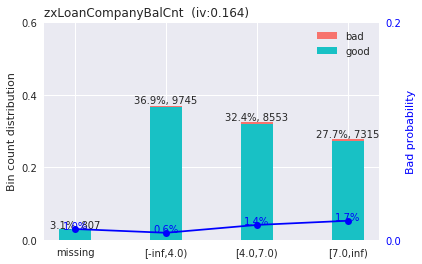

In [303]:
sc.woebin_plot(rf_bin_dicts,x=['zxLoanCompanyBalCnt'])
plt.savefig('badprob.png',bbox_inches = 'tight')

In [298]:
sc.woebin(train_x,y='tag',x='zxAccountCnt',breaks_list={'zxAccountCnt':[5,15]})

[INFO] creating woe binning ...


{'zxAccountCnt':        variable         bin  count  count_distr   good  bad   badprob  \
 0  zxAccountCnt     missing   2393     0.090575   2359   34  0.014208   
 1  zxAccountCnt  [-inf,5.0)   7461     0.282400   7368   93  0.012465   
 2  zxAccountCnt  [5.0,15.0)  11941     0.451968  11814  127  0.010636   
 3  zxAccountCnt  [15.0,inf)   4625     0.175057   4563   62  0.013405   
 
         woe    bin_iv  total_iv   breaks  is_special_values  
 0  0.174469  0.003005  0.011999  missing               True  
 1  0.041800  0.000504  0.011999      5.0              False  
 2 -0.118752  0.006018  0.011999     15.0              False  
 3  0.115500  0.002472  0.011999      inf              False  }

## 2.4 按照IV值与badprob单调性筛选特征

In [365]:
all_bin_df_dicts = {**rf_bin_dicts,**lab_bin_dicts,**woeenc_bin_dicts}
feas_info = fef.filter_fea(all_bin_df_dicts)

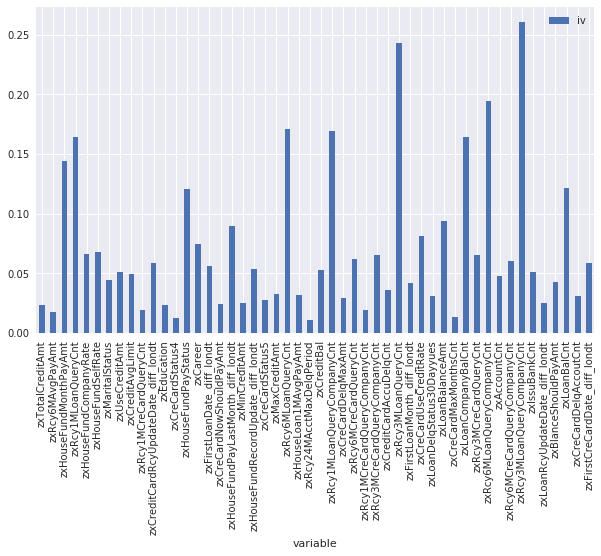

In [66]:
sele_feas = set(feas_info[feas_info['iv'] > 0.01].sort_values('iv',ascending=False).index)
# sele_feas = set(feas_info.index)-iv_drop_feas
feas_info.reindex(sele_feas).plot.bar(figsize=(10,6))
plt.savefig('IV.png',bbox_inches = 'tight')

In [366]:
train_x = train_x[sele_feas]
test_x = test_x[sele_feas]

## 2.5 特征woe编码

In [367]:
train_x_woe = sc.woebin_ply(train_x,rf_bin_dicts)
test_x_woe = sc.woebin_ply(test_x,rf_bin_dicts)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [368]:
labsele_feas = sele_feas & set(labelencode_feas)
train_x_woe = sc.lab_woe_ply(train_x_woe,labsele_feas,lab_bin_dicts)
test_x_woe = sc.lab_woe_ply(test_x_woe,labsele_feas,lab_bin_dicts)

In [369]:
woesele_feas = sele_feas & set(woeenc_feas)
train_x_woe = sc.lab_woe_ply(train_x_woe,woesele_feas,woeenc_bin_dicts)
test_x_woe = sc.lab_woe_ply(test_x_woe,woesele_feas,woeenc_bin_dicts)

In [370]:
train_x_woe = train_x_woe.astype(float)
test_x_woe = test_x_woe.astype(float)

## 2.6 相关性筛选

In [58]:
# fs = FeatureSelector(train_x_woe,labels=train_y)
# fs.identify_collinear(0.7)
# fs.identify_single_unique()
# fs_drop_feas = fs.check_removal()
# train_x_woe.drop(fs_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(fs_drop_feas,axis=1,inplace=True)

In [59]:
all_bin_df_dicts['zxHouseFundMonthPayAmt']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,zxHouseFundMonthPayAmt,missing,16688,0.631643,16455,233,0.013962,0.156755,0.016769,0.143678,missing,True
1,zxHouseFundMonthPayAmt,"[-inf,500.0)",4606,0.174338,4548,58,0.012592,0.052102,0.000485,0.143678,500.0,False
2,zxHouseFundMonthPayAmt,"[500.0,900.0)",1874,0.070931,1860,14,0.007471,-0.475173,0.012806,0.143678,900.0,False
3,zxHouseFundMonthPayAmt,"[900.0,inf)",3252,0.123089,3241,11,0.003383,-1.271640,0.113617,0.143678,inf,False


In [60]:
all_bin_df_dicts['zxHouseFundPayStatus']

,zxHouseFundPayStatus,total,bad,variable,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,missing,16688,233,zxHouseFundPayStatus,16455,0.013962,0.630363,0.737342,-0.156755,0.016769,0.120537
1,封存,3196,44,zxHouseFundPayStatus,3152,0.013767,0.120748,0.139241,-0.142499,0.002635,0.120537
2,缴交,5823,31,zxHouseFundPayStatus,5792,0.005324,0.221882,0.098101,0.816144,0.101023,0.120537
3,销户,713,8,zxHouseFundPayStatus,705,0.011220,0.027007,0.025316,0.064655,0.000109,0.120537


## 2.7 逐步回归筛选特征

In [61]:
# step_drop_feas,res = fef.step_logit(train_x_woe,train_y)
# train_x_woe.drop(step_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(step_drop_feas,axis=1,inplace=True)

## 2.8 lightgbm筛选特征（回选）

In [62]:
# lightgbm_feas = {'zxRcy3MLoanQueryCnt','zxCreCardUseCreditRate','zxHouseFundPayStatus','zxRcy6MLoanQueryCompanyCnt','zxLoanCompanyBalCnt',
#                 'zxHouseFundMonthPayAmt','zxLoanBalCnt','zxLoanBalanceAmt','zxCreditCardAccuDelqCnt','zxLoanRcyDelqDate_diff_londt',
#                  'zxFirstLoanDate_diff_londt','zxFirstLoanMonth_diff_londt','zxCreditCardDelqStatus6To12Months'}
# lightgbm_feas = {f+'_woe' for f in lightgbm_feas if f in num_feas}
# step_drop_feas = set(step_drop_feas)-lightgbm_feas
# train_x_woe.drop(step_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(step_drop_feas,axis=1,inplace=True)

# 三、建立模型

## 3.1 逻辑回归

In [371]:
res = fef.step_logit(train_x_woe,train_y,selection='sample')

Optimization terminated successfully.
         Current function value: 0.063823
         Iterations 10
                                                         Results: Logit
Model:                                    Logit                                 Pseudo R-squared:                      0.016    
Dependent Variable:                       y                                     AIC:                                   3470.4108
Date:                                     2021-02-09 10:26                      BIC:                                   3871.3228
No. Observations:                         26420                                 Log-Likelihood:                        -1686.2  
Df Model:                                 48                                    LL-Null:                               -1712.8  
Df Residuals:                             26371                                 LLR p-value:                           0.28374  
Converged:                                1.0000   

In [372]:
train_x_woe['_const'] = 1
test_x_woe['_const'] = 1

In [373]:
predict_train_y = res.predict(train_x_woe.values)
predict_test_y = res.predict(test_x_woe.values)

In [374]:
roc_auc_score(train_y,predict_train_y)

0.61445933646136

In [375]:
roc_auc_score(test_y,predict_test_y)

0.5067890491913605

In [376]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(train_x_woe,train_y)
predict_train_y = lr.predict_proba(train_x_woe)[:,1]
print(roc_auc_score(train_y,predict_train_y))
predict_test_y = lr.predict_proba(test_x_woe)[:,1]
print(roc_auc_score(test_y,predict_test_y))
fpr,tpr,_= roc_curve(test_y,predict_test_y)
print(abs(fpr-tpr).max())

0.6162567960873158
0.5055488811541778
0.04556089507665778


In [379]:
smo = SMOTE(sampling_strategy = {1:850},random_state = 42)
x_smo,y_smo = smo.fit_sample(train_x_woe,train_y)
lr = LogisticRegression()
lr.fit(x_smo,y_smo)
predict_train_y = lr.predict_proba(x_smo)[:,1]
print(roc_auc_score(y_smo,predict_train_y))
predict_test_y = lr.predict_proba(test_x_woe)[:,1]
print(roc_auc_score(test_y,predict_test_y))
fpr,tpr,_= roc_curve(test_y,predict_test_y)
print(abs(fpr-tpr).max())

0.6335157785148997
0.5067443584512819
0.04507718353698287
